<a href="https://colab.research.google.com/github/Reem-Almasri/flowering_time/blob/main/cr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!git clone https://github.com/mariiabav/AIO_vigna.git

fatal: destination path 'AIO_vigna' already exists and is not an empty directory.


In [74]:
!git clone https://github.com/Tihon99/AIO_vigna-master_updated.git

fatal: destination path 'AIO_vigna-master_updated' already exists and is not an empty directory.


In [75]:
!pip install keras_tuner

In [76]:
import h5py
import numpy as np
from PIL import Image
import scipy
import logging
import seaborn as sns
import os
import cv2 as cv
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate)
from keras.layers import BatchNormalization
from keras.utils import to_categorical
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import regularizers

In [77]:
!pip install smogn

In [105]:
# original_classes = [
#     [0, 23, 31],
#     [1, 34, 40],  # !!!
#     [2, 41, 47],
#     [3, 48, 54],
#     [4, 55, 61],
#     [5, 62, 68],
#     [6, 69, 75],
#     [7, 76, 83],
#     [8, 84, 90],
#     [9, 91, 97],
#     [10, 98, 105],
#     [11, 106, 157],  # !!!
#     [12, 175, 181],
#     [13, 182, 188],
#     [14, 189, 195],
#     [15, 198, 204],
#     [16, 205, 211],
#     [17, 212, 218],
#     [18, 230, 250],  # !!!
# ]

# balanced_classes = [
#     [0, 23, 37],
#     [1, 38, 41],
#     [2, 42, 45],
#     [3, 46, 48],
#     [4, 49, 52],
#     [5, 53, 55],
#     [6, 56, 63],
#     [7, 64, 78],
#     [8, 79, 93],
#     [9, 94, 108],
#     [10, 109, 157],  # !!!
#     [11, 175, 181],
#     [12, 182, 188],
#     [13, 189, 204],
#     [14, 205, 218],
#     [15, 230, 250],  # !!!
# ]

# large_classes = [
#     [0, 23, 43],
#     [1, 44, 50],
#     [2, 51, 60],
#     [3, 60, 70],
#     [4, 71, 150],
#     [5, 151, 200],
#     [6, 201, 250]
# ]

# predicted_classes = [
#     [0, 23, 40],
#     [1, 41, 42],
#     [2, 43, 44],
#     [3, 45, 47],
#     [4, 48, 52],
#     [5, 53, 59],
#     [6, 60, 75],
#     [7, 76, 101],
#     [8, 102, 156],
#     [9, 157, 188],
#     [10, 189, 250]
# ]

def load_images_from_folder(folder):

    r_labels=[]
    im=[]
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            aio_plant = filename.split("_")
            flowering_time = aio_plant[2].split(".")[0]
            if int(flowering_time)<=140:
                 r_labels.append(np.uint8(flowering_time))
                 im.append(np.asarray(img).astype(np.float32))

    plt.hist(r_labels, color = 'blue', edgecolor = 'black', bins = int(180/5))
    # plt.figure()


    # df = pd.DataFrame(zip(im,r_labels),columns=['images','labels'])
    # print (df)
    # plt.hist(df['labels'], color = 'blue', edgecolor = 'black', bins = int(180/5))
    # plt.figure()

    # Count the occurrences of each label in the 'labels' column
    # label_counts = df['labels'].value_counts()

    # # Print the label counts
    # for label, count in label_counts.items():
    #     print(label, ":", count)

    # # Convert labels to hashable integers
    # df['labels'] = df['labels'].astype(int)
    # # Convert images column to string representation of NumPy array
    # df['images'] = df['images'].apply(lambda x: np.array2string(x.flatten(), separator=','))
    # sm= smogn.smoter(
    #     data = df,  ## pandas dataframe
    #     y = 'labels',  ## string ('header name')
    #     k = 250,
    #     rel_thres = 0.10,         ## positive real number (0 < R < 1)
    #     )

    # sm['images'] = sm['images'].apply(lambda x: np.fromstring(x[1:-1], sep=','))
    # df['labels'] = df['labels'].astype(int)

    # print(sm)
    # plt.hist(sm['labels'], color = 'blue', edgecolor = 'black', bins = int(180/5))
    # # Count the occurrences of each label in the 'labels' column
    # label_counts = sm['labels'].value_counts()

    # # Print the label counts
    # for label, count in label_counts.items():
    #     print(label, ":", count)


    # print(df.shape, sm.shape)
    return np.array(im), np.array(r_labels)

In [80]:
def plot_confusion(confusion_mat):
    ax = sns.heatmap(confusion_mat, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels for all vigna\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    fig = ax.get_figure()
    fig.savefig('./confusion_matrix-all.png')
    plt.show()

    plt.matshow(confusion_mat)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_accuracy(history, fold):
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(80)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Точность на обучении')
    plt.plot(epochs_range, val_acc, label='Точность на валидации')
    plt.legend(loc='lower right')
    plt.title('Точность')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Потери на обучении')
    plt.plot(epochs_range, val_loss, label='Потери на валидации')
    plt.legend(loc='upper right')
    plt.title('Потери')

    plt.savefig('./' + str(fold) + '_vigna_turned.png')
    plt.show()

In [88]:
# #1
# def build_model(hp):
#     inputs1 = keras.Input(shape=(5, 28, 3))
#     inputs2 = keras.Input(shape=(5, 28, 3))
#     c = concatenate([inputs1, inputs2])

#     c = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation=hp.Choice(
#                                         'first_conv2d_activation',
#                                         ['relu', 'tanh'],))(c)
#     if hp.Boolean("need_batch_norm_after_first_conv2d"):
#       c=BatchNormalization()(c)

#     c=MaxPooling2D(pool_size=(2, 2))(c)
#     c=Conv2D(hp.Int('second_conv2d_out_channels',
#         min_value=32, max_value=64, step=32,),
#              kernel_size=(3, 3), padding='same', strides=(1, 1), input_shape=(2, 11, 32),
#         activation=hp.Choice('second_conv2d_activation',['relu', 'tanh'],))(c)
#     if hp.Boolean("need_batch_norm_after_second_conv2d"):
#        c=BatchNormalization()(c)
#     c=MaxPooling2D(pool_size=(2, 2))(c)
#     c=Flatten(name='flatten')(c)
#     c=Dense(128, activation='relu', kernel_regularizer='l1_l2')(c)
#     c=Dropout(0.5)(c)
#     # Outputs
#     r_output =Dense(1, activation='linear',kernel_regularizer='l1_l2', name='Regression')(c)
#     c_output=Dense(7, activation='softmax',kernel_regularizer='l1_l2', name="Classification")(c)

#     model = keras.Model(inputs=[inputs1, inputs2], outputs=[c_output, r_output], name='model')

#     model.compile(
#     loss={
#         "Classification": keras.losses.CategoricalCrossentropy(),
#         "Regression": keras.losses.Huber(delta=0.02),}, #2
#         # "Regression": keras.losses.mse,},

#     metrics = {
#         "Classification": 'accuracy',
#         "Regression": 'mse'},
#         optimizer=keras.optimizers.RMSprop(1e-3), #3
#     loss_weights={
#           "Classification": 0.5,
#           "Regression": 0.2 })
#     keras.utils.plot_model(model, "model.png", show_shapes=True)
#     model.summary()
#     return model

In [99]:
#1
def build_model(hp):
    inputs1 = keras.Input(shape=(5, 28, 3))

    c = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation=hp.Choice(
                                        'first_conv2d_activation',
                                        ['relu', 'tanh'],))(inputs1)
    if hp.Boolean("need_batch_norm_after_first_conv2d"):
      c=BatchNormalization()(c)

    c=MaxPooling2D(pool_size=(2, 2))(c)
    c=Conv2D(hp.Int('second_conv2d_out_channels',
        min_value=32, max_value=64, step=32,),
             kernel_size=(3, 3), padding='same', strides=(1, 1), input_shape=(2, 11, 32),
        activation=hp.Choice('second_conv2d_activation',['relu', 'tanh'],))(c)
    if hp.Boolean("need_batch_norm_after_second_conv2d"):
       c=BatchNormalization()(c)
    c=MaxPooling2D(pool_size=(2, 2))(c)
    c=Flatten(name='flatten')(c)
    c=Dense(128, activation='relu', kernel_regularizer='l1_l2')(c)
    # c=Dropout(0.5)(c)
    # Outputs
    r_output =Dense(1, activation='linear',kernel_regularizer='l1_l2', name='Regression')(c)
    c_output=Dense(7, activation='softmax',kernel_regularizer='l1_l2', name="Classification")(c)

    model = keras.Model(inputs=inputs1, outputs=[c_output, r_output], name='model')

    model.compile(
    loss={
        "Classification": keras.losses.CategoricalCrossentropy(),
        "Regression": keras.losses.Huber(delta=0.02),},
        # "Regression": keras.losses.mse,},

    metrics = {
        "Classification": 'accuracy',
        "Regression": 'mse'},
        optimizer=keras.optimizers.RMSprop(1e-3),
    loss_weights={
          "Classification": 0.5,
          "Regression": 0.2 })
    keras.utils.plot_model(model, "model.png", show_shapes=True)
    model.summary()
    return model

In [83]:
# 2
# def build_model(hp):
#     inputs1 = keras.Input(shape=(5, 28, 3))
#     inputs2 = keras.Input(shape=(5, 28, 3))
#     c = concatenate([inputs1, inputs2])

#     c = Conv2D(hp.Int('first_conv2d_out_channels', min_value=32, max_value=128, step=32),
#                kernel_size=(3, 3), padding='same', strides=(1, 1),
#                activation=hp.Choice('first_conv2d_activation', ['relu', 'tanh']))(c)

#     if hp.Boolean("need_batch_norm_after_first_conv2d"):
#         c = BatchNormalization()(c)

#     c = MaxPooling2D(pool_size=(2, 2))(c)

#     c = Conv2D(hp.Int('second_conv2d_out_channels', min_value=64, max_value=256, step=64),
#                kernel_size=(3, 3), padding='same', strides=(1, 1),
#                activation=hp.Choice('second_conv2d_activation', ['relu', 'tanh']))(c)

#     if hp.Boolean("need_batch_norm_after_second_conv2d"):
#         c = BatchNormalization()(c)

#     c = MaxPooling2D(pool_size=(2, 2))(c)
#     c = Flatten(name='flatten')(c)
#     c = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(c)
#     c = Dropout(0.5)(c)

#     # Outputs
#     r_output = Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(0.001), name='Regression')(c)
#     c_output = Dense(5, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001), name="Classification")(c)

#     model = keras.Model(inputs=[inputs1, inputs2], outputs=[c_output, r_output], name='model')

#     model.compile(
#         loss={
#             "Classification": keras.losses.CategoricalCrossentropy(),
#             "Regression": keras.losses.Huber(delta=0.01)
#         },
#         metrics={
#             "Classification": 'accuracy',
#             "Regression": 'mse'
#         },
#         optimizer=keras.optimizers.RMSprop(1e-3))

#     keras.utils.plot_model(model, "model.png", show_shapes=True)
#     model.summary()

#     return model

In [108]:
# large_classes = [
#     [0, 0, 43],
#     [1, 44, 50],
#     [2, 51, 60],
#     [3, 61, 70],
#     [4, 71, 150],
#     [5, 151, 200],
#     [6, 201, 260]
# ]
large_classes = [
    [0, 0, 43],
    [1, 44, 50],
    [2, 51, 60],
    [3, 61, 70],
    [4, 71, 150]
]
# labels to classes:
def to_classes(data):
    classes=[]
    for d in data:
      for i in large_classes:
        if d in range(i[1], i[2]+1):
           classes.append(i[0])

    print(set(classes))
    plt.figure()
    plt.hist(classes, color = 'blue', edgecolor = 'black', bins = int(180/5))

    return np.array(classes)

 # for i in data:
    #   if int(i)<=50:  #256
    #      classes.append(0)
    #   if int(i)>50 and int(i)<=60: #247
    #     classes.append(1)
    #   if int(i)>60 and int(i)<=70: #124
    #     classes.append(2)
    #   if int(i)>70 and int(i)<=120: #154
    #     classes.append(3)
    #   if int(i)>120 and int(i)<=250: #222
    #     classes.append(4)

{0, 1, 2, 3, 4}


array([4, 2, 1, 1, 3, 0, 2, 4, 2, 0, 2, 1, 4, 2, 4, 2, 4, 2, 4, 4, 2, 2,
       2, 2, 1, 2, 0, 1, 1, 1, 4, 2, 2, 0, 1, 2, 2, 2, 2, 4, 2, 1, 2, 1,
       3, 2, 3, 0, 2, 2, 2, 1, 1, 2, 2, 2, 3, 1, 4, 4, 1, 1, 2, 2, 1, 4,
       4, 4, 3, 0, 1, 4, 1, 3, 3, 3, 1, 1, 2, 2, 0, 2, 3, 3, 4, 4, 2, 1,
       2, 2, 0, 4, 2, 2, 2, 2, 2, 0, 3, 1, 2, 0, 3, 3, 1, 1, 2, 2, 2, 3,
       2, 3, 0, 1, 2, 1, 2, 4, 1, 1, 2, 0, 2, 4, 3, 2, 0, 1, 4, 0, 1, 3,
       0, 2, 2, 0, 1, 1, 4, 4, 2, 2, 1, 1, 0, 2, 1, 4, 4, 3, 2, 0, 0, 4,
       1, 4, 4, 2, 1, 1, 2, 4, 1, 2, 4, 3, 2, 1, 2, 4, 4, 2, 1, 1, 2, 4,
       1, 4, 2, 0, 1, 0, 1, 2, 2, 3, 2, 4, 2, 4, 0, 2, 3, 4, 4, 2, 3, 4,
       3, 2, 4, 0, 3, 2, 2, 1, 1, 2, 2, 0, 2, 1, 3, 3, 0, 1, 2, 4, 4, 0,
       3, 4, 0, 3, 2, 4, 0, 1, 0, 1, 0, 4, 2, 2, 4, 4, 2, 2, 3, 2, 0, 1,
       1, 1, 2, 4, 4, 0, 4, 4, 1, 2, 2, 4, 0, 0, 2, 0, 4, 4, 2, 1, 3, 3,
       3, 0, 3, 3, 2, 1, 3, 2, 0, 2, 3, 3, 4, 1, 0, 2, 1, 3, 3, 4, 4, 2,
       1, 0, 3, 3, 1, 4, 2, 4, 1, 2, 2, 2, 4, 2, 3,

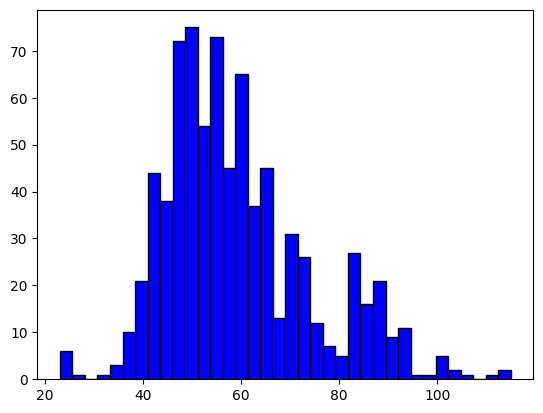

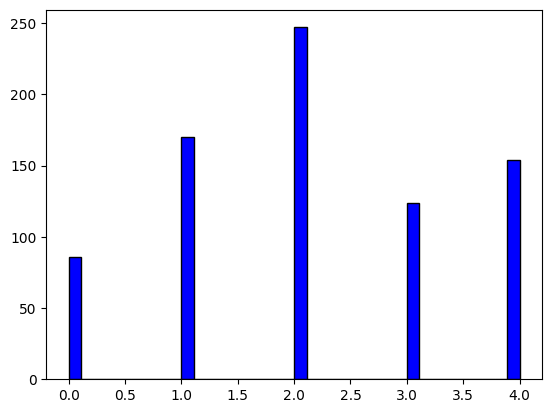

In [109]:
# images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')
# to_classes(labels)

In [85]:
# from re import X
# def train():
#     logging.getLogger("tensorflow").setLevel(logging.ERROR)
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
#     K.set_image_data_format('channels_last')

#     # data_images, data_labels, images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')
#     images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')


#     train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.7, test_size=0.3, random_state=42)
#     clusters=to_classes(labels)
#     train_classes=to_classes(train_labels)
#     test_classes=to_classes(test_labels)

#     train_vectors = to_categorical(train_classes, 7)
#     test_vectors = to_categorical(test_classes, 7)

#     plt.hist(clusters, color = 'blue', edgecolor = 'black', bins = int(180/5))
#     plt.figure()

#     plt.hist(labels, color = 'blue', edgecolor = 'black', bins = int(180/5))


#     tuner = kt.RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=6,
#         seed=1234,
#         overwrite=True
#     )
#     tuner.search([train_images, train_images], [train_vectors, train_labels], epochs=80, batch_size=64, validation_split=0.2)
#     tuner.results_summary()
#     model = tuner.get_best_models()[0]

#     num_folds = 10
#     batch_size = 64
#     verbosity = 1
#     acc_per_fold = []
#     c_loss_per_fold = []
#     r_loss_per_fold = []
#     mse_per_fold = []

#     # Define the K-fold Cross Validator
#     fold_no = 1
#     kfold = KFold(n_splits=num_folds, shuffle=True)
#     for tr, valid in kfold.split(train_images, train_labels):
#         print('------------------------------------------------------------------------')
#         print(f'Training for fold {fold_no} ...')
#         # Train the model
#         history= model.fit([train_images[tr], train_images[tr]], [train_vectors[tr], train_labels[tr]],
#                                       batch_size=batch_size,
#                                       epochs=100,
#                                       verbose=verbosity,
#                                       validation_split=0.2)

#         scores = model.evaluate([train_images[valid], train_images[valid]], [train_vectors[valid], train_labels[valid]], verbose=0)

#         c_loss=scores[1]
#         r_loss = scores[2]
#         mse=scores[4]
#         acc=scores[3]

#         r_loss_per_fold.append(r_loss)
#         mse_per_fold.append(mse)
#         acc_per_fold.append(acc*100)
#         c_loss_per_fold.append(c_loss)

#         fold_no += 1

#         predictions=model.predict([test_images, test_images])[1]
#         # x=0
#         # for i in range(len(test_labels)):
#         #   print("Actual:" , test_labels[i], ",Predicted:",np.round(predictions[i]), "  (",predictions[i],")")
#         #   if (test_labels[i]==np.round(predictions[i])):
#         #      x+=1
#         # print('Guessed', x, 'from:', len(test_labels))

#         # Plot regression
#         plt.figure()
#         plt.scatter(test_labels, predictions, color='b')
#         plt.xlabel('Actual Values')
#         plt.ylabel('Predicted Values')
#         plt.title('Regression')
#         plt.show()

#         cconfusion = confusion_matrix(np.argmax(test_vectors, axis=-1), np.argmax(model.predict([test_images, test_images])[0], axis=-1))
#         print(cconfusion)
#         ax = sns.heatmap(cconfusion, annot=True, cmap='Blues')
#         ax.set_title('Confusion Matrix with labels for all vigna\n\n')
#         ax.set_xlabel('\nPredicted Values')
#         ax.set_ylabel('Actual Values ')
#         fig = ax.get_figure()
#         fig.savefig('./confusion_matrix-val.png')
#         plt.show()

#     img=cv.imread('/content/model.png')
#     plt.imshow(img)
#     plt.show()

#     # list all data in history
#     # print(history.history.keys())
#     # # summarize history for loss
#     plt.plot(history.history['Classification_loss'],color = 'r')
#     plt.plot(history.history['val_Classification_loss'],color = 'g')
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['Train CNN loss', 'Test CNN loss'], loc='center left')

#     plt.figure()
#     plt.plot(history.history['Regression_loss'] ,color = 'b')
#     plt.plot(history.history['val_Regression_loss'] ,color = 'y')
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['Train Regression loss','Test Regression loss'], loc='center left')
#     plt.show()

#     print('Accuracy in all folds:', acc_per_fold)
#     print('C loss in all folds:', c_loss_per_fold)
#     print('Huber in all folds:', r_loss_per_fold)
#     print('MSE in all folds:', mse_per_fold)

#     # == Provide average scores ==
#     print('\nAverage scores for all folds:')
#     print(f'> Classification Accuracy: {np.mean(acc_per_fold)} (+/- {np.std(acc_per_fold)})')
#     print(f'> Classification Loss: {np.mean(c_loss_per_fold)} (+/- {np.std(c_loss_per_fold)})')
#     print(f'> Regression Huber: {np.mean(r_loss_per_fold)} (+/- {np.std(r_loss_per_fold)})')
#     print(f'> Regression MSE: {np.mean(mse_per_fold)}')

In [112]:
from re import X
def train():
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    K.set_image_data_format('channels_last')

    # data_images, data_labels, images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')
    images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')


    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.7, test_size=0.3, random_state=42)
    clusters=to_classes(labels)
    train_classes=to_classes(train_labels)
    test_classes=to_classes(test_labels)

    train_vectors = to_categorical(train_classes, 7)
    test_vectors = to_categorical(test_classes, 7)


    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=6,
        seed=1234,
        overwrite=True
    )
    tuner.search(train_images, [train_vectors, train_labels], epochs=80, batch_size=64, validation_split=0.2)
    tuner.results_summary()
    model = tuner.get_best_models()[0]

    num_folds = 10
    batch_size = 128
    verbosity = 1
    acc_per_fold = []
    c_loss_per_fold = []
    r_loss_per_fold = []
    mse_per_fold = []

    # Define the K-fold Cross Validator
    fold_no = 1
    kfold = KFold(n_splits=num_folds, shuffle=True)
    for tr, valid in kfold.split(train_images, train_labels):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        # Train the model
        history= model.fit(train_images[tr], [train_vectors[tr], train_labels[tr]],
                                      batch_size=batch_size,
                                      epochs=80,
                                      verbose=verbosity,
                                      validation_split=0.2)

        scores = model.evaluate(train_images[valid], [train_vectors[valid], train_labels[valid]], verbose=0)

        c_loss=scores[1]
        r_loss = scores[2]
        mse=scores[4]
        acc=scores[3]

        r_loss_per_fold.append(r_loss)
        mse_per_fold.append(mse)
        acc_per_fold.append(acc*100)
        c_loss_per_fold.append(c_loss)

        fold_no += 1

        predictions=model.predict(test_images)[1]
        # x=0
        # for i in range(len(test_labels)):
        #   print("Actual:" , test_labels[i], ",Predicted:",np.round(predictions[i]), "  (",predictions[i],")")
        #   if (test_labels[i]==np.round(predictions[i])):
        #      x+=1
        # print('Guessed', x, 'from:', len(test_labels))

        # Plot regression
        plt.figure()
        plt.scatter(test_labels, predictions, color='b')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Regression')
        plt.show()

        cconfusion = confusion_matrix(np.argmax(test_vectors, axis=-1), np.argmax(model.predict(test_images)[0], axis=-1))
        print(cconfusion)
        ax = sns.heatmap(cconfusion, annot=True, cmap='Blues')
        ax.set_title('Confusion Matrix with labels for all vigna\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ')
        fig = ax.get_figure()
        fig.savefig('./confusion_matrix-val.png')
        plt.show()

    img=cv.imread('/content/model.png')
    plt.imshow(img)
    plt.show()

    # list all data in history
    # print(history.history.keys())
    # # summarize history for loss
    # plt.plot(history.history['Classification_loss'],color = 'r')
    # plt.plot(history.history['Regression_loss'] ,color = 'b')
    # plt.plot(history.history['val_Classification_loss'],color = 'g')
    # plt.plot(history.history['val_Regression_loss'] ,color = 'y')
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['Train CNN loss', 'Train Regression loss','Test CNN loss', 'Test Regression loss'], loc='center left')
    # plt.show()


    plt.plot(history.history['Classification_loss'],color = 'r')
    plt.plot(history.history['val_Classification_loss'],color = 'g')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train CNN loss', 'Test CNN loss'], loc='center left')

    plt.figure()
    plt.plot(history.history['Regression_loss'] ,color = 'b')
    plt.plot(history.history['val_Regression_loss'] ,color = 'y')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train Regression loss','Test Regression loss'], loc='center left')
    plt.show()


    print('Accuracy in all folds:', acc_per_fold)
    print('C loss in all folds:', c_loss_per_fold)
    print('Huber in all folds:', r_loss_per_fold)
    print('MSE in all folds:', mse_per_fold)

    # == Provide average scores ==
    print('\nAverage scores for all folds:')
    print(f'> Classification Accuracy: {np.mean(acc_per_fold)} (+/- {np.std(acc_per_fold)})')
    print(f'> Classification Loss: {np.mean(c_loss_per_fold)} (+/- {np.std(c_loss_per_fold)})')
    print(f'> Regression Huber: {np.mean(r_loss_per_fold)} (+/- {np.std(r_loss_per_fold)})')
    print(f'> Regression MSE: {np.mean(mse_per_fold)}')

Trial 6 Complete [00h 00m 23s]
val_loss: 1.353131890296936

Best val_loss So Far: 1.2091050148010254
Total elapsed time: 00h 02m 10s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
first_conv2d_activation: tanh
need_batch_norm_after_first_conv2d: True
second_conv2d_out_channels: 64
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: False
Score: 1.2091050148010254

Trial 2 summary
Hyperparameters:
first_conv2d_activation: relu
need_batch_norm_after_first_conv2d: True
second_conv2d_out_channels: 32
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: True
Score: 1.332027554512024

Trial 5 summary
Hyperparameters:
first_conv2d_activation: relu
need_batch_norm_after_first_conv2d: False
second_conv2d_out_channels: 32
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: True
Score: 1.353131890296936

Trial 4 summary
Hyperparameters:
first_conv2d_ac

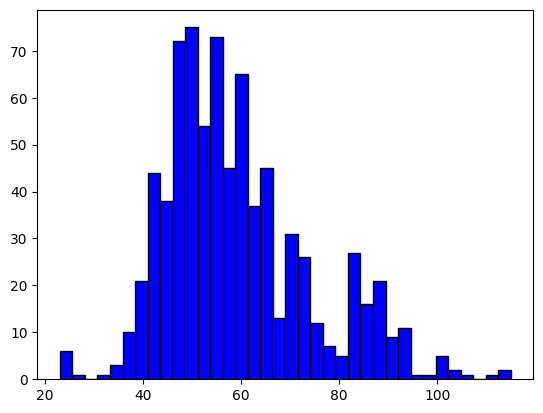

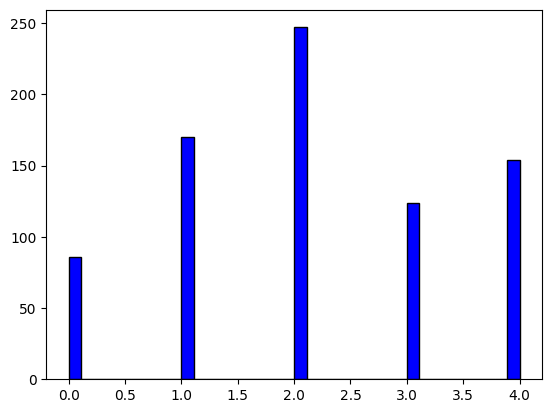

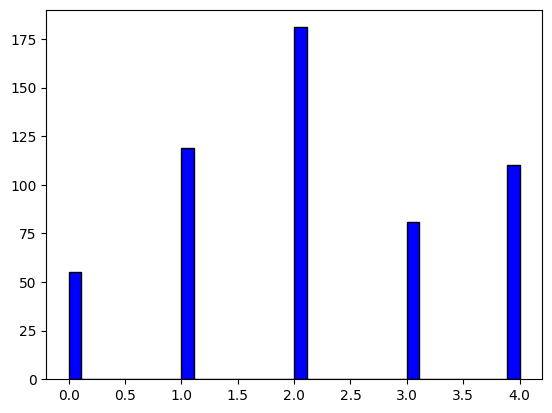

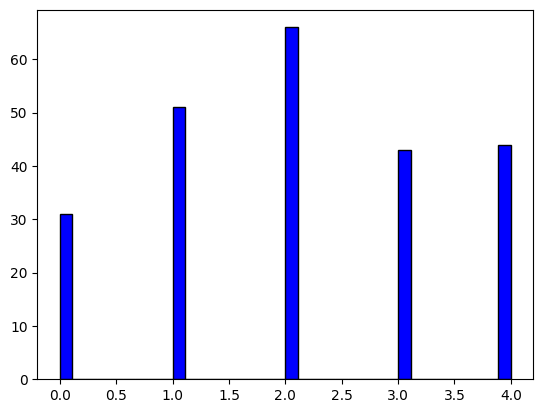

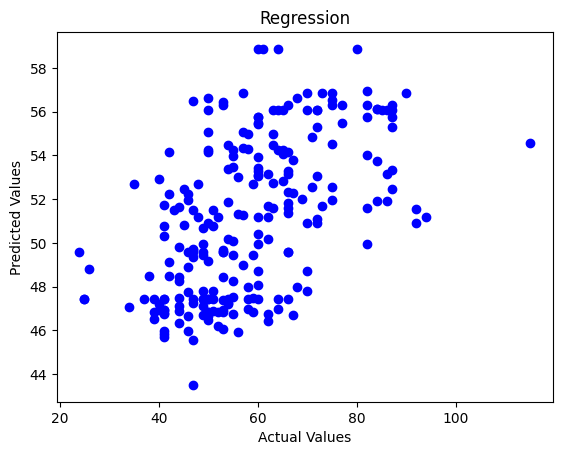

8/8 [==============================] - 0s 4ms/step
[[13  7 11  0  0]
 [12 10 25  0  4]
 [15  5 33  0 13]
 [ 1  1 30  0 11]
 [ 0  0 15  1 28]]


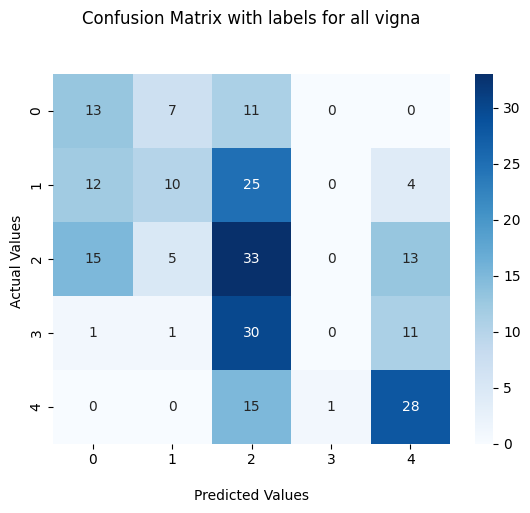

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/80
4/4 [==============================] - 0s 69ms/step - loss: 1.0298 - Classification_loss: 1.1733 - Regression_loss: 0.2133 - Classification_accuracy: 0.5485 - Regression_mse: 233.9149 - val_loss: 1.1799 - val_Classification_loss: 1.4607 - val_Regression_loss: 0.2344 - val_Classification_accuracy: 0.3434 - val_Regression_mse: 255.1682
Epoch 2/80
4/4 [==============================] - 0s 47ms/step - loss: 1.0299 - Classification_loss: 1.1734 - Regression_loss: 0.2117 - Classification_accuracy: 0.5332 - Regression_mse: 228.5233 - val_loss: 1.1632 - val_Classification_loss: 1.4338 - val_Regression_loss: 0.2271 - val_Classification_accuracy: 0.3939 - val_Regression_mse: 236.7856
Epoch 3/80
4/4 [==============================] - 0s 46ms/step - loss: 1.0249 - Classification_loss: 1.1661 - Regression_loss: 0.2096 - Classification_accuracy: 0.5230 - Regression_mse: 223.4093 - val_loss: 1.

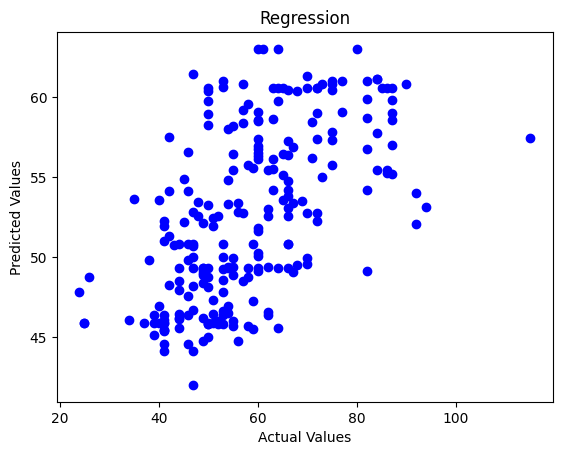

8/8 [==============================] - 0s 4ms/step
[[ 2 15 13  1  0]
 [ 0 20 27  1  3]
 [ 2 15 41  0  8]
 [ 0  6 28  3  6]
 [ 0  3 19  4 18]]


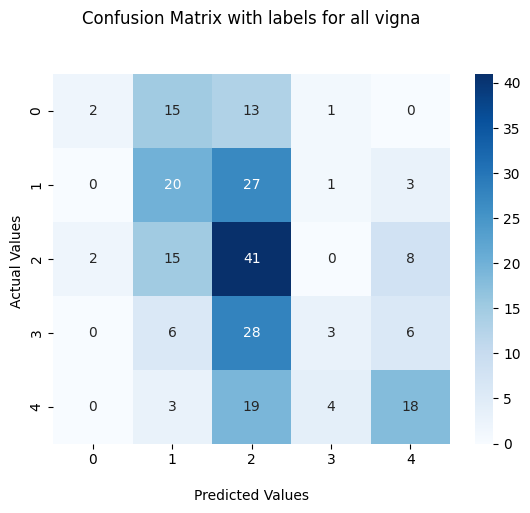

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/80
4/4 [==============================] - 0s 57ms/step - loss: 0.9902 - Classification_loss: 1.0964 - Regression_loss: 0.2055 - Classification_accuracy: 0.5612 - Regression_mse: 209.9048 - val_loss: 1.3510 - val_Classification_loss: 1.8111 - val_Regression_loss: 0.2143 - val_Classification_accuracy: 0.3838 - val_Regression_mse: 197.8845
Epoch 2/80
4/4 [==============================] - 0s 31ms/step - loss: 0.9918 - Classification_loss: 1.0995 - Regression_loss: 0.2028 - Classification_accuracy: 0.5255 - Regression_mse: 199.0712 - val_loss: 1.3235 - val_Classification_loss: 1.7525 - val_Regression_loss: 0.2195 - val_Classification_accuracy: 0.3838 - val_Regression_mse: 214.2954
Epoch 3/80
4/4 [==============================] - 0s 40ms/step - loss: 1.0130 - Classification_loss: 1.1414 - Regression_loss: 0.2035 - Classification_accuracy: 0.5204 - Regression_mse: 200.4201 - val_loss: 1.

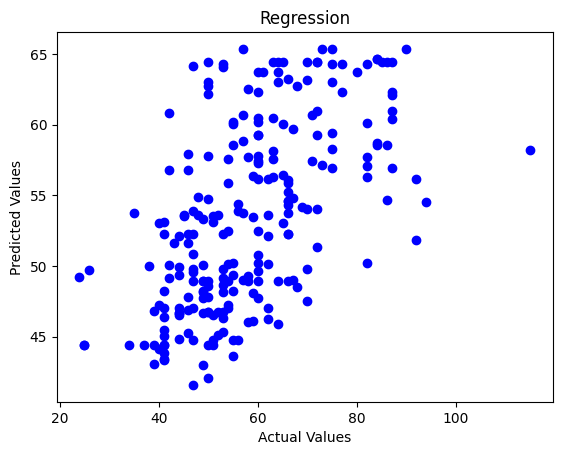

8/8 [==============================] - 0s 4ms/step
[[ 0  5 23  3  0]
 [ 1  8 32  7  3]
 [ 1  6 46  6  7]
 [ 0  0 30  6  7]
 [ 0  0 17  8 19]]


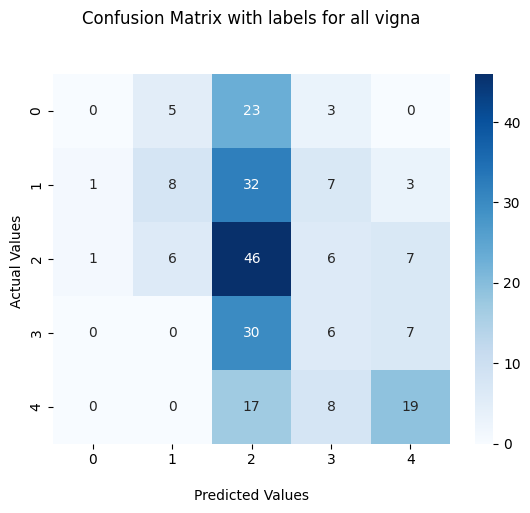

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/80
4/4 [==============================] - 0s 47ms/step - loss: 0.9708 - Classification_loss: 1.0507 - Regression_loss: 0.1937 - Classification_accuracy: 0.5510 - Regression_mse: 186.8975 - val_loss: 1.2804 - val_Classification_loss: 1.6646 - val_Regression_loss: 0.2070 - val_Classification_accuracy: 0.3333 - val_Regression_mse: 202.8791
Epoch 2/80
4/4 [==============================] - 0s 35ms/step - loss: 0.9451 - Classification_loss: 1.0010 - Regression_loss: 0.1928 - Classification_accuracy: 0.6122 - Regression_mse: 184.4758 - val_loss: 1.3123 - val_Classification_loss: 1.7278 - val_Regression_loss: 0.2018 - val_Classification_accuracy: 0.3131 - val_Regression_mse: 188.5586
Epoch 3/80
4/4 [==============================] - 0s 36ms/step - loss: 0.9600 - Classification_loss: 1.0288 - Regression_loss: 0.1929 - Classification_accuracy: 0.5893 - Regression_mse: 183.3690 - val_loss: 1.

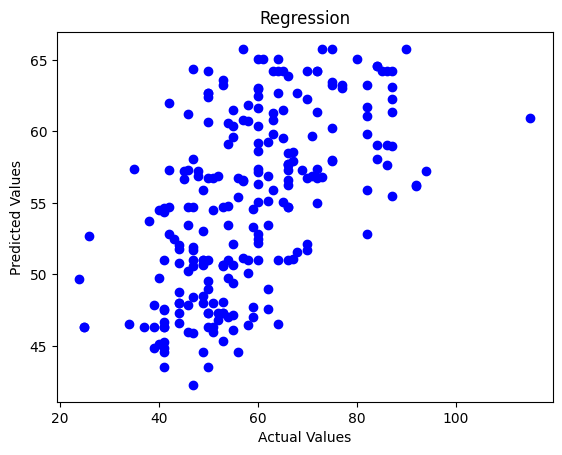

8/8 [==============================] - 0s 4ms/step
[[14  2 14  0  1]
 [12  4 31  0  4]
 [15  3 37  0 11]
 [ 2  0 31  0 10]
 [ 0  3 20  1 20]]


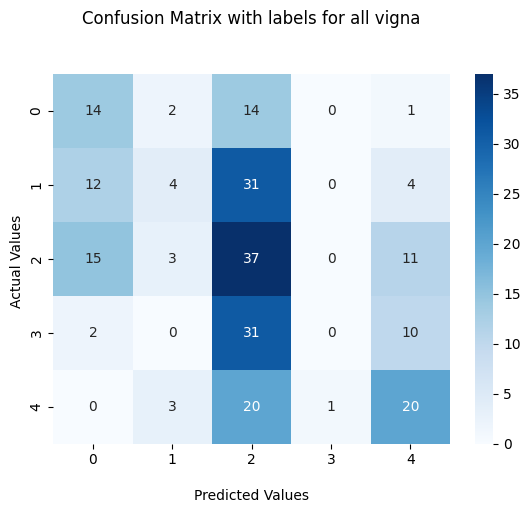

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/80
4/4 [==============================] - 0s 50ms/step - loss: 0.9420 - Classification_loss: 0.9752 - Regression_loss: 0.1989 - Classification_accuracy: 0.5944 - Regression_mse: 194.5288 - val_loss: 1.3997 - val_Classification_loss: 1.8840 - val_Regression_loss: 0.2208 - val_Classification_accuracy: 0.3333 - val_Regression_mse: 221.3775
Epoch 2/80
4/4 [==============================] - 0s 35ms/step - loss: 0.8928 - Classification_loss: 0.8796 - Regression_loss: 0.2000 - Classification_accuracy: 0.6301 - Regression_mse: 198.7997 - val_loss: 1.4988 - val_Classification_loss: 2.0733 - val_Regression_loss: 0.2280 - val_Classification_accuracy: 0.2020 - val_Regression_mse: 236.7276
Epoch 3/80
4/4 [==============================] - 0s 44ms/step - loss: 0.9390 - Classification_loss: 0.9681 - Regression_loss: 0.2027 - Classification_accuracy: 0.6020 - Regression_mse: 205.1896 - val_loss: 1.

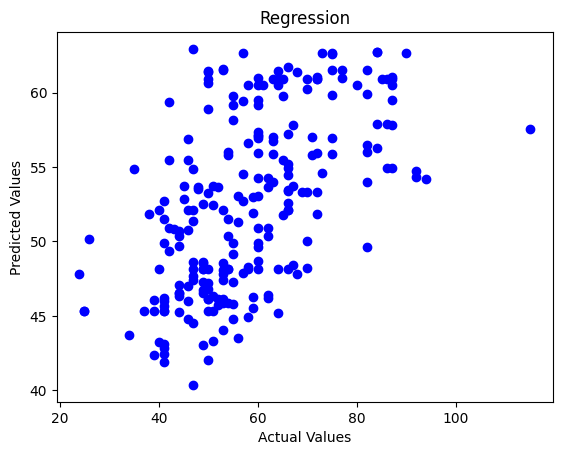

8/8 [==============================] - 0s 4ms/step
[[ 3 18  6  4  0]
 [ 1 27  8 12  3]
 [ 4 27 13 17  5]
 [ 0  7 11 18  7]
 [ 0  6  6 18 14]]


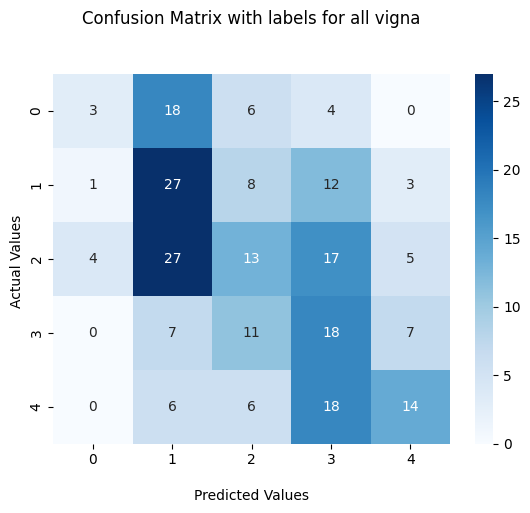

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/80
4/4 [==============================] - 0s 50ms/step - loss: 0.9143 - Classification_loss: 0.9153 - Regression_loss: 0.1927 - Classification_accuracy: 0.6480 - Regression_mse: 187.0446 - val_loss: 1.4014 - val_Classification_loss: 1.8810 - val_Regression_loss: 0.2089 - val_Classification_accuracy: 0.3030 - val_Regression_mse: 201.2371
Epoch 2/80
4/4 [==============================] - 0s 37ms/step - loss: 0.8862 - Classification_loss: 0.8609 - Regression_loss: 0.1894 - Classification_accuracy: 0.6735 - Regression_mse: 177.9840 - val_loss: 1.3683 - val_Classification_loss: 1.8168 - val_Regression_loss: 0.2111 - val_Classification_accuracy: 0.3232 - val_Regression_mse: 205.0947
Epoch 3/80
4/4 [==============================] - 0s 37ms/step - loss: 0.8700 - Classification_loss: 0.8297 - Regression_loss: 0.1890 - Classification_accuracy: 0.6709 - Regression_mse: 180.8854 - val_loss: 1.

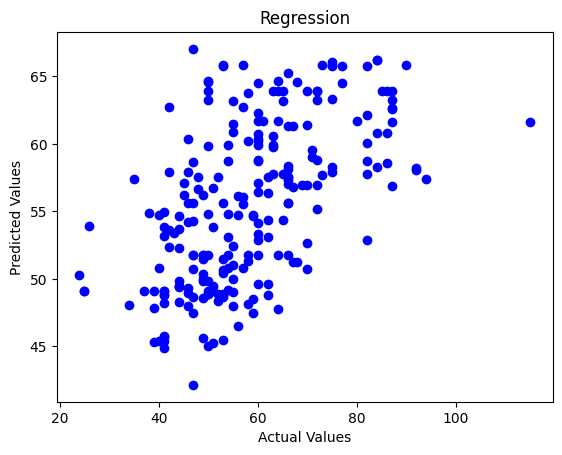

8/8 [==============================] - 0s 4ms/step
[[ 8  3 19  0  1]
 [11  6 29  1  4]
 [10  5 40  1 10]
 [ 3  1 28  1 10]
 [ 0  3 18  4 19]]


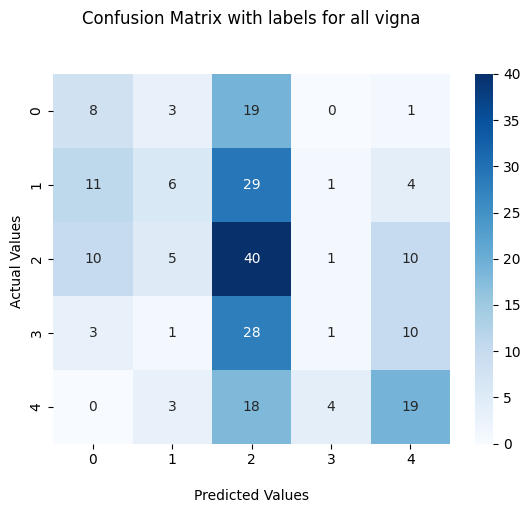

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/80
4/4 [==============================] - 0s 46ms/step - loss: 0.8709 - Classification_loss: 0.8273 - Regression_loss: 0.1832 - Classification_accuracy: 0.6692 - Regression_mse: 162.2302 - val_loss: 1.4951 - val_Classification_loss: 2.0609 - val_Regression_loss: 0.2156 - val_Classification_accuracy: 0.2525 - val_Regression_mse: 214.6838
Epoch 2/80
4/4 [==============================] - 0s 36ms/step - loss: 0.8838 - Classification_loss: 0.8528 - Regression_loss: 0.1849 - Classification_accuracy: 0.6641 - Regression_mse: 169.7072 - val_loss: 1.4769 - val_Classification_loss: 2.0286 - val_Regression_loss: 0.2085 - val_Classification_accuracy: 0.3535 - val_Regression_mse: 196.1047
Epoch 3/80
4/4 [==============================] - 0s 35ms/step - loss: 0.8708 - Classification_loss: 0.8281 - Regression_loss: 0.1825 - Classification_accuracy: 0.6845 - Regression_mse: 163.6801 - val_loss: 1.

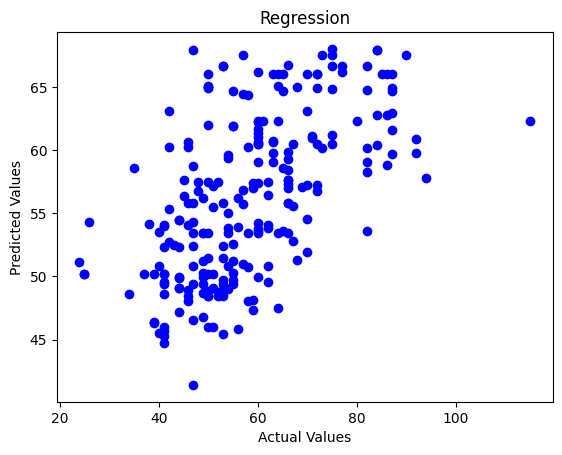

8/8 [==============================] - 0s 4ms/step
[[ 5  3 19  1  3]
 [ 6  8 26  4  7]
 [ 7  5 36  5 13]
 [ 1  2 23  6 11]
 [ 0  1 10  5 28]]


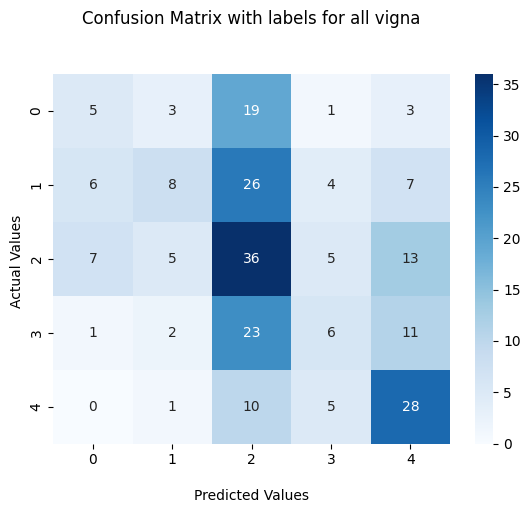

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/80
4/4 [==============================] - 0s 53ms/step - loss: 0.8444 - Classification_loss: 0.7675 - Regression_loss: 0.1913 - Classification_accuracy: 0.7201 - Regression_mse: 186.3962 - val_loss: 1.5170 - val_Classification_loss: 2.1020 - val_Regression_loss: 0.2156 - val_Classification_accuracy: 0.2828 - val_Regression_mse: 215.0189
Epoch 2/80
4/4 [==============================] - 0s 39ms/step - loss: 0.8372 - Classification_loss: 0.7538 - Regression_loss: 0.1899 - Classification_accuracy: 0.7277 - Regression_mse: 181.8839 - val_loss: 1.5120 - val_Classification_loss: 2.0887 - val_Regression_loss: 0.2211 - val_Classification_accuracy: 0.2727 - val_Regression_mse: 231.1762
Epoch 3/80
4/4 [==============================] - 0s 34ms/step - loss: 0.8440 - Classification_loss: 0.7659 - Regression_loss: 0.1913 - Classification_accuracy: 0.6947 - Regression_mse: 184.6031 - val_loss: 1.

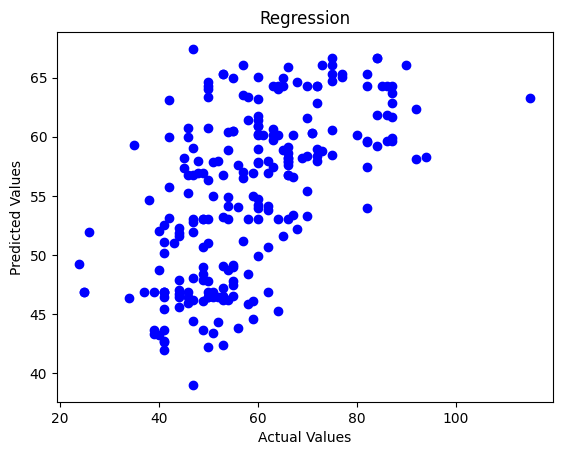

8/8 [==============================] - 0s 4ms/step
[[ 5  4 19  2  1]
 [ 9  7 21  9  5]
 [ 7  5 34 13  7]
 [ 0  0 23 11  9]
 [ 0  2 17  9 16]]


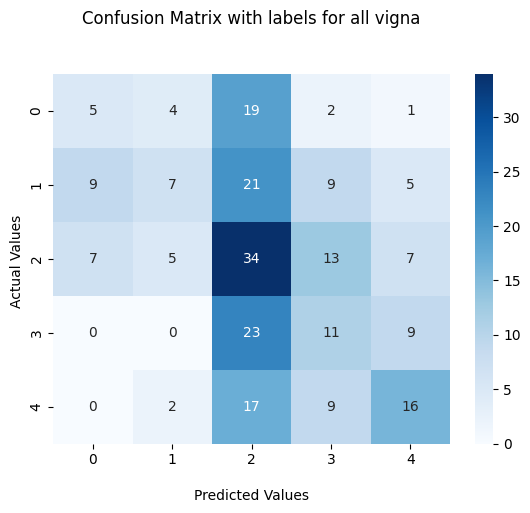

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/80
4/4 [==============================] - 0s 49ms/step - loss: 0.8243 - Classification_loss: 0.7208 - Regression_loss: 0.1856 - Classification_accuracy: 0.7074 - Regression_mse: 167.8705 - val_loss: 1.6661 - val_Classification_loss: 2.3886 - val_Regression_loss: 0.2152 - val_Classification_accuracy: 0.3333 - val_Regression_mse: 197.7588
Epoch 2/80
4/4 [==============================] - 0s 42ms/step - loss: 0.8328 - Classification_loss: 0.7371 - Regression_loss: 0.1839 - Classification_accuracy: 0.7125 - Regression_mse: 166.2662 - val_loss: 1.6294 - val_Classification_loss: 2.3161 - val_Regression_loss: 0.2144 - val_Classification_accuracy: 0.3333 - val_Regression_mse: 196.7151
Epoch 3/80
4/4 [==============================] - 0s 38ms/step - loss: 0.8258 - Classification_loss: 0.7234 - Regression_loss: 0.1842 - Classification_accuracy: 0.7074 - Regression_mse: 164.8125 - val_loss: 1.

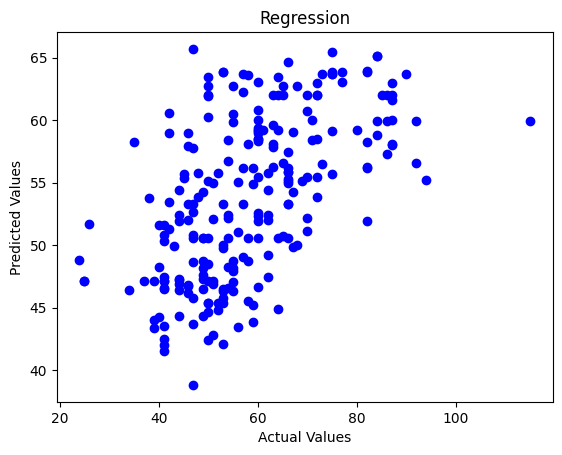

8/8 [==============================] - 0s 4ms/step
[[ 4 14 10  3  0]
 [ 3 22  9 14  3]
 [ 7 19 14 19  7]
 [ 0  5 13 22  3]
 [ 0  4  6 27  7]]


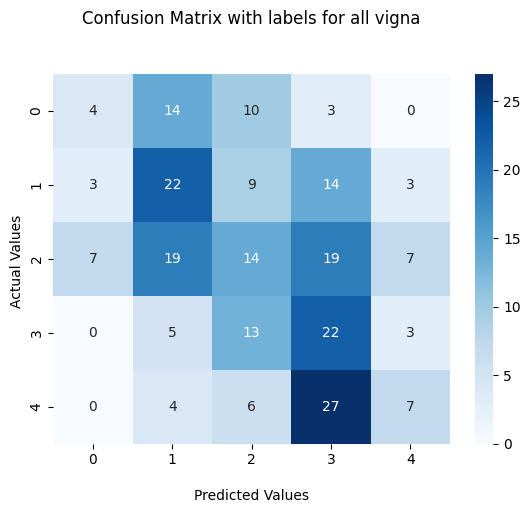

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/80
4/4 [==============================] - 0s 48ms/step - loss: 0.8333 - Classification_loss: 0.7335 - Regression_loss: 0.1864 - Classification_accuracy: 0.7023 - Regression_mse: 179.1619 - val_loss: 1.7534 - val_Classification_loss: 2.5620 - val_Regression_loss: 0.2091 - val_Classification_accuracy: 0.3636 - val_Regression_mse: 200.7968
Epoch 2/80
4/4 [==============================] - 0s 41ms/step - loss: 0.8537 - Classification_loss: 0.7756 - Regression_loss: 0.1841 - Classification_accuracy: 0.6997 - Regression_mse: 170.4522 - val_loss: 1.7101 - val_Classification_loss: 2.4745 - val_Regression_loss: 0.2114 - val_Classification_accuracy: 0.2727 - val_Regression_mse: 210.7533
Epoch 3/80
4/4 [==============================] - 0s 34ms/step - loss: 0.8308 - Classification_loss: 0.7291 - Regression_loss: 0.1863 - Classification_accuracy: 0.7176 - Regression_mse: 180.6948 - val_loss: 1

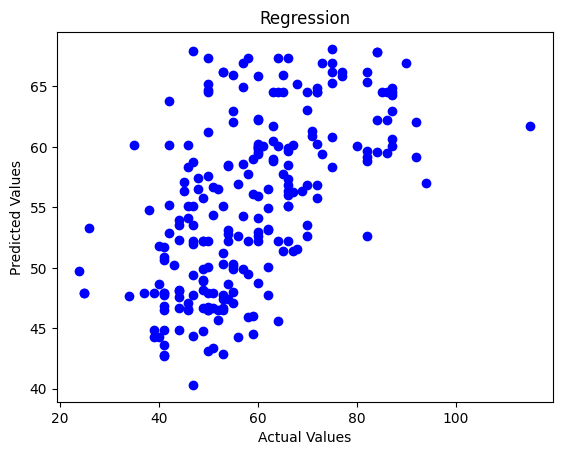

8/8 [==============================] - 0s 4ms/step
[[ 5 14 11  0  1]
 [ 6 31  7  3  4]
 [ 7 26 17  5 11]
 [ 0 14 16  4  9]
 [ 0  5 11  7 21]]


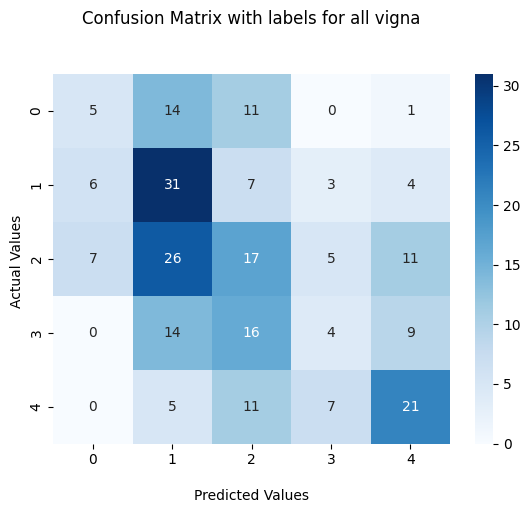

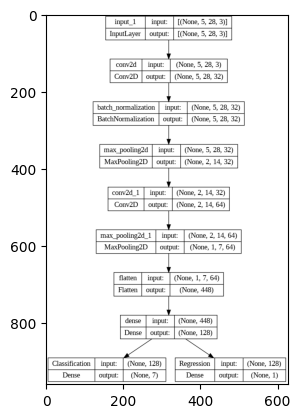

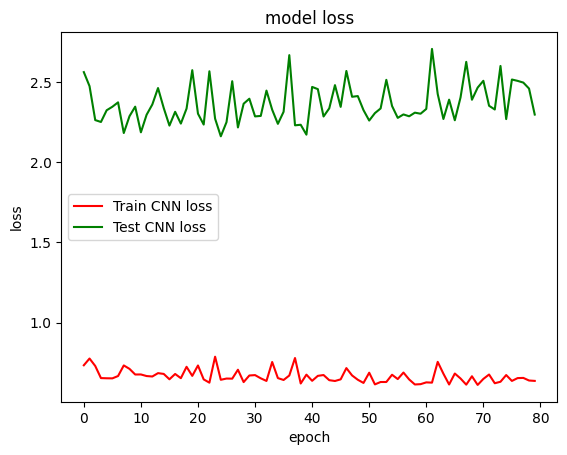

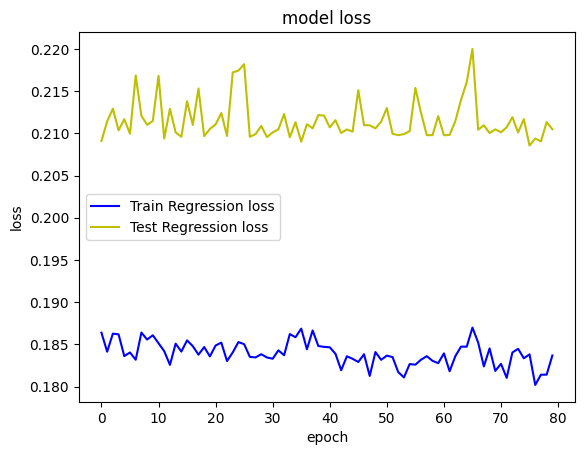

Accuracy in all folds: [43.63636374473572, 30.909091234207153, 43.63636374473572, 54.54545617103577, 45.45454680919647, 50.90909004211426, 64.81481194496155, 59.25925970077515, 40.74074029922485, 55.55555820465088]
C loss in all folds: [1.3629175424575806, 1.5730732679367065, 1.383595585823059, 1.2205582857131958, 1.3673063516616821, 1.5548689365386963, 1.1721069812774658, 1.0747714042663574, 1.3648698329925537, 1.4046216011047363]
Huber in all folds: [0.20723536610603333, 0.2286849319934845, 0.1965663582086563, 0.23906582593917847, 0.1776377111673355, 0.21224583685398102, 0.24687471985816956, 0.15592969954013824, 0.166985884308815, 0.18274129927158356]
MSE in all folds: [223.29190063476562, 266.0369567871094, 198.45916748046875, 245.16123962402344, 140.26907348632812, 193.3376922607422, 331.4478454589844, 106.4557113647461, 151.18101501464844, 145.43313598632812]

Average scores for all folds:
> Classification Accuracy: 48.94612818956375 (+/- 9.47790849245778)
> Classification Loss: 1

In [113]:
train()